In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="llama-3.3-70b-versatile")

In [3]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

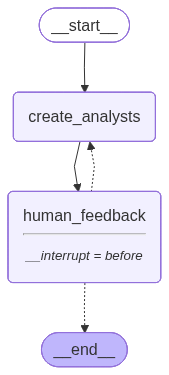

In [4]:
from langgraph.graph import START, StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions= """You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide the creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and/or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(
        topic = topic,
        human_analyst_feedback = human_analyst_feedback,
        max_analysts = max_analysts
    )

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)] + [HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysts to the state
    return {"analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """No-op node that should be interrupted on"""
    pass

def should_continue(state: GenerateAnalystsState):
    """Return the next node to execute"""

    # Check if human feedback
    human_analyst_feedback=state.get("human_analyst_feedback", None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END


# Adds nodes and edges
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback",
    should_continue,
    ['create_analysts', END]
)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

graph

In [5]:
# Input
max_analysts = 3
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    # Review
    analysts = event.get("analysts", "")
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Dr. Kim is an expert in artificial intelligence and machine learning, with a focus on the benefits and challenges of adopting LangGraph as an agent framework. She is interested in exploring the potential applications of LangGraph in natural language processing and its impact on the field of AI research.
--------------------------------------------------
Name: Professor Liam Chen
Affiliation: MIT
Role: Computer Science Professor
Description: Professor Chen is a renowned expert in computer science and software engineering, with a focus on the design and development of agent frameworks. He is concerned about the scalability and flexibility of LangGraph and its potential to support complex AI systems.
--------------------------------------------------
Name: Dr. Sofia Patel
Affiliation: McKinsey
Role: Industry Consultant
Description: Dr. Patel is a consultant with expertise in AI adoption and implementati

In [6]:
# Get state and look at the next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": "Add in someone from a startup to add an enterpreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a2bf2-7a0c-6517-8002-8d0a1ae3853b'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Dr. Kim is an expert in artificial intelligence and machine learning, with a focus on the benefits and challenges of adopting LangGraph as an agent framework. She is interested in exploring the potential applications of LangGraph in natural language processing and its impact on the field of AI research.
--------------------------------------------------
Name: Professor Liam Chen
Affiliation: MIT
Role: Computer Science Professor
Description: Professor Chen is a renowned expert in computer science and software engineering, with a focus on the design and development of agent frameworks. He is concerned about the scalability and flexibility of LangGraph and its potential to support complex AI systems.
--------------------------------------------------
Name: Dr. Sofia Patel
Affiliation: McKinsey
Role: Industry Consultant
Description: Dr. Patel is a consultant with expertise in AI adoption and implementati

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a2bf2-b536-64bb-8004-a5481678b1c3'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [11]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

In [12]:
final_state.next

()

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Rachel Kim
Affiliation: University of California
Role: Researcher
Description: Expert in AI frameworks with a focus on LangGraph benefits for research institutions
--------------------------------------------------
Name: Ethan Thompson
Affiliation: CEO of AI Startup
Role: Entrepreneur
Description: Startup founder with experience in adopting LangGraph for innovative products
--------------------------------------------------
Name: Professor Liam Chen
Affiliation: Stanford University
Role: Academic
Description: Specialist in AI adoption with a focus on LangGraph integration in academic settings
--------------------------------------------------


### Conduct Interview
---
#### Generate Question
##### The analyst will ask questions to the expert.

In [14]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [15]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """Node to generate a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)] + messages)

    # Write messages to state
    return {"messages": [question]}

### Generate Answer : Parallelization
#### The expert will gather information from multiple sources in parallel to answer questions

In [3]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [17]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

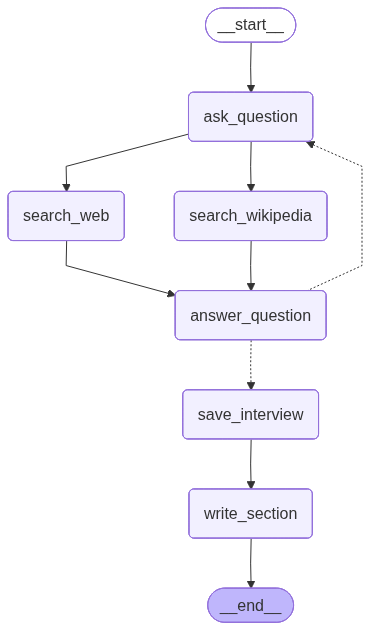

In [18]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    """Retrieves docs from web search"""
    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    

    search_query = structured_llm.invoke(
        [search_instructions] + 
        state["messages"] + 
        [HumanMessage(content="Generate a search query based on the conversation above.")]
    )

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n--\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>' for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    """Retrieve docs from wikipedia"""

    # search query
    structured_llm = llm.with_structured_output(SearchQuery)

    search_query = structured_llm.invoke(
        [search_instructions] + 
        state["messages"] + 
        [HumanMessage(content="Generate a search query based on the conversation above.")]
    )

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    """Node to answer a question"""

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to the state
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    """Save interviews"""

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, name: str = "expert"):
    """Route between question and answer"""

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'
    
    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):
    """Node to answer a question"""

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

interview_graph

In [19]:
# Pick one analyst
analysts[0]

Analyst(affiliation='University of California', name='Dr. Rachel Kim', role='Researcher', description='Expert in AI frameworks with a focus on LangGraph benefits for research institutions')

In [32]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({
    "analyst": analysts[0],
    "messages": messages,
    "max_num_turns": 2
}, thread)
Markdown(interview['sections'][0])

## Enhancing AI Frameworks with LangGraph
### Summary
The development of artificial intelligence (AI) agents has become increasingly complex, with a growing need for structured programming and state management. LangGraph, an extension of LangChain, has emerged as a powerful tool for building advanced AI applications. By abstracting the complexities of state management and workflow coordination, LangGraph enables developers to create intelligent, responsive, and high-quality AI agents. According to [1], LangGraph simplifies the creation of complex workflows, enhances error handling and state management, and facilitates coordination between multiple agents. This is particularly useful for applications such as virtual assistants, customer service bots, and educational agents that require extended, meaningful dialogues [5]. The use of LangGraph has been shown to improve the capabilities of AI agents in various industries, including [2] and [6].

Some of the key benefits of using LangGraph include:
1. **Simplified workflow creation**: LangGraph allows developers to structure AI logic as a graph, making it easier to map complex flows [2].
2. **Enhanced state management**: LangGraph provides a state management system that maintains and updates context or memory throughout the interaction [1].
3. **Improved agent coordination**: LangGraph facilitates coordination between multiple agents, enabling the development of sophisticated AI applications [1].

As noted in [3], LangGraph uses a graph-based architecture to model and manage the intricate relationships between various components of an AI agent workflow. This approach enables users to scale artificial intelligence workflows without slowing down or sacrificing efficiency. Furthermore, LangGraph's ability to illuminate the processes within an AI workflow provides full transparency of the agent's state, making it an essential tool for developing complex AI applications [3].

### Sources
[1] https://medium.com/@pankaj_pandey/building-advanced-ai-agents-with-langgraph-enhancing-your-llm-applications-c43c6803a9d2 
[2] https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph 
[3] https://www.ibm.com/think/topics/langgraph 
[4] https://medium.com/@ken_lin/langgraph-a-framework-for-building-stateful-multi-agent-llm-applications-a51d5eb68d03 
[5] https://aws.amazon.com/blogs/machine-learning/build-multi-agent-systems-with-langgraph-and-amazon-bedrock/ 
[6] https://www.ibm.com/think/topics/langgraph#:~:text=LangGraph%2C%20created%20by%20LangChain%2C%20is 
[7] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence 
[8] https://en.wikipedia.org/wiki/Timeline_of_computing_2020%E2%80%93present 
[9] https://en.wikipedia.org/wiki/Semantic_Web 
[10] https://en.wikipedia.org/wiki/React_(software)

### Parallelize the interviews - Map-Reduce (Send() API)

In [20]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

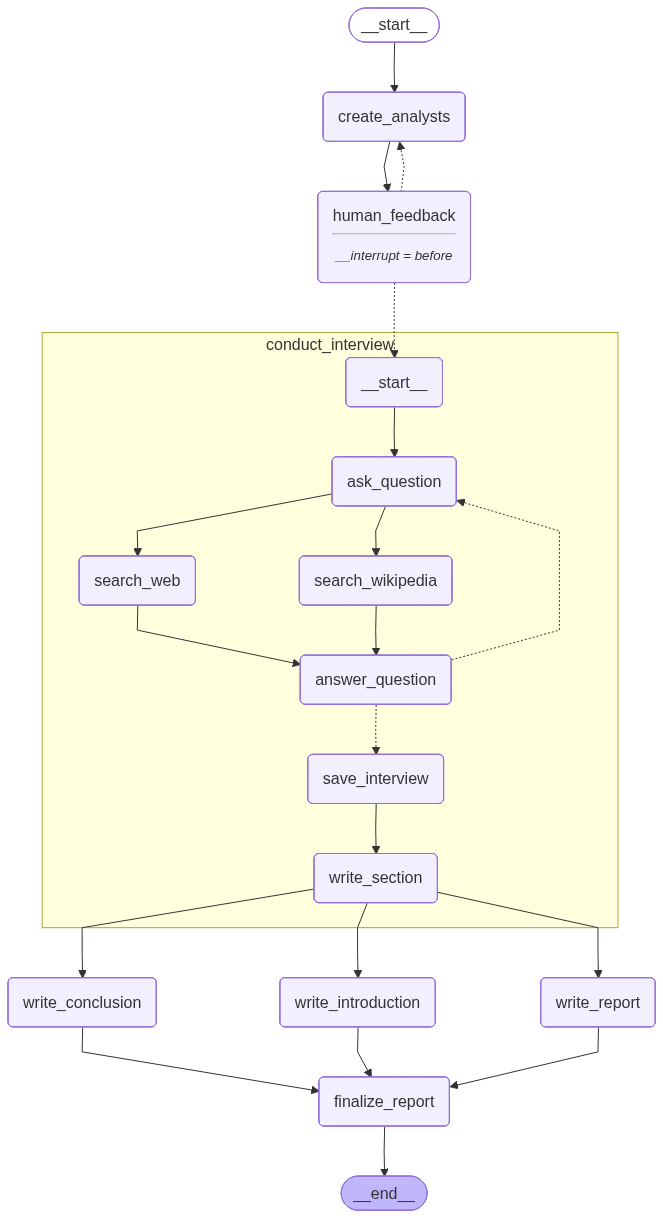

In [21]:
from langgraph.types import Send

def initiate_all_interviews(state: ResearchGraphState):
    """This is the map step where we run each interview sub-graph using Send API"""

    # Check if human feedback
    human_analyst_feedback = state.get("human_analyst_feedback")
    if human_analyst_feedback:
        # Return to create analysts
        return "create_analysts"
    
    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic=state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                            "messages": [HumanMessage(
                                                content=f"So you said you were writing an article on {topic}?"
                                            )]}) for analyst in state["analysts"]]
    
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}   

intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}""" 

def write_introduction(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

from IPython.display import display, Image
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [22]:
# Inputs
max_analysts = 1 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Investigating the potential of LangGraph to improve natural language processing tasks and its applications in various industries.
--------------------------------------------------


In [23]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a2bf3-e0a0-600d-8002-657bb547caa6'}}

In [24]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Alex Chen
Affiliation: Stanford University
Role: AI Researcher
Description: Investigating the potential of LangGraph to improve natural language processing tasks and its applications in various industries.
--------------------------------------------------
Name: Alex Chen
Affiliation: Gen AI Native Startup
Role: CEO
Description: Focused on the benefits of adopting LangGraph for startup growth and innovation.
--------------------------------------------------


In [25]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0a2bf4-2425-6b63-8004-b78944d0d452'}}

In [26]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
write_conclusion
--Node--
write_introduction
--Node--
write_report
--Node--
finalize_report


In [27]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# Benefits of Adopting LangGraph as an Agent Framework
## Introduction
LangGraph offers a powerful framework for building and managing AI agents, driving startup growth and innovation. With its modular design, LangGraph supports evolving business needs, simplifies development, and reduces costs. This report explores the benefits of adopting LangGraph, including built-in state management, smarter language handling, and multi-agent collaboration, revolutionizing AI development for efficient and personalized solutions.

---


The adoption of LangGraph as an agent framework can bring numerous benefits to startups, particularly in driving growth and innovation. LangGraph is designed for scale, allowing businesses to expand workflows, introduce new agents, and adjust logic without starting from scratch [1]. This modular design supports evolving needs, whether it's growing teams, launching new products, or adapting to policy changes. The framework offers built-in state management, smarter language and context handling, and multi-agent collaboration [1], making it an ideal solution for AI initiatives. Additionally, LangGraph simplifies the development process, minimizes development time, and reduces costs [2]. By leveraging LangGraph, startups can create more efficient, effective, and personalized AI solutions, enabling them to stay ahead of the competition. The potential of LangGraph to revolutionize AI development is further highlighted by its ability to support deep learning [6] and social networking services [7], making it a versatile and powerful tool for businesses.


---

## Conclusion
In conclusion, adopting LangGraph as an agent framework offers numerous benefits for startups, including **unlocking growth and innovation**, **simplified development**, and **cost reduction**. With its modular design, built-in state management, and multi-agent collaboration, LangGraph enables businesses to create efficient, effective, and personalized AI solutions, driving them ahead of the competition.

## Sources
1. https://www.ema.co/additional-blogs/addition-blogs/building-ai-agents-langgraph
2. https://www.linkedin.com/pulse/how-build-custom-ai-agent-using-langgraph-framework-stafeeka-r-4uiie
3. https://medium.com/@hao.l/why-langgraph-stands-out-as-an-exceptional-agent-framework-44806d969cc6
4. https://www.rapidinnovation.io/post/ai-agents-in-langgraph
5. https://www.ibm.com/think/topics/langgraph
6. https://en.wikipedia.org/wiki/Deep_learning
7. https://en.wikipedia.org/wiki/Social_networking_service